In [1]:
import sys
sys.path.append("../ext_deps/ScaleNet")

In [40]:
import os

import torch
import torchvision.transforms as transforms
import numpy as np
from pathlib import Path
from tqdm import tqdm, trange

import cv2 as cv
import matplotlib.pyplot as plt
from scipy.linalg import null_space

from ScaleNet.scalenet import scalenet_network as scaleNetwork
from ScaleNet.general_modules import get_scale

from hloc.visualization import plot_keypoints, plot_matches, read_image, add_text, cm_RdGn

In [3]:
path_scalenet = "../ext_deps/ScaleNet/ScaleNet/weights/vgg_scalenet_weights.pth"

In [4]:
train_data = Path("../image-matching-challenge-2023/train")
dataset = "haiper"
scene = "bike"

In [5]:
n_images = len(os.listdir(train_data / dataset / scene / "images"))

In [6]:
torch.set_grad_enabled(False)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [7]:
# Define ScaleNet model
model_scale = scaleNetwork(device=device)
checkpoint = torch.load(path_scalenet)

/home/vathys00/anaconda3/envs/imc/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vathys00/anaconda3/envs/imc/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
model_scale.to_scale.load_state_dict(checkpoint['state_dict'])
model_scale.eval()
model_scale.to(device)

scalenet_network(
  (softmax): Softmax(dim=1)
  (extractor): VGGPyramid(
    (level_0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (level_1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (level_2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (level_3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): 

In [9]:
imgs = [img for img in os.listdir(train_data / dataset / scene / "images")]

In [10]:
scale_matrix = np.ndarray((n_images, n_images))

In [11]:
# Calculate the relative scales between images
for i in trange(len(imgs)):
    for j in trange(i, len(imgs), leave=False):
        if i == j:
            scale_matrix[i, j] = 1
        else:
            img1_path = str(train_data / dataset / scene / "images" / imgs[i])
            img2_path = str(train_data / dataset / scene / "images" / imgs[j])
            scale_factor = get_scale(model_scale, img1_path, img2_path, transforms.ToTensor(), device)

            scale_matrix[i, j] = scale_factor
            scale_matrix[j, i] = 1 / scale_factor            

100%|██████████| 15/15 [00:39<00:00,  2.61s/it]


In [91]:
global_scales = np.array([])

In [92]:
# Helper function to calculate sum_{j = 0; j != i}^n x_j
def sum_minus(x, ind):
    return np.sum(x) - x[ind]

So to solve for the global scales of the images, what we do is solve the minimization problem:
$ \min_{x \in X} \| x \left( \frac{1}{x} \right)^T - A \|_F $ 
with the constraint that $\| x \|^2 = 1$.
where $x$ is vector of global scales for each image, and $A$ is a matrix of relative scales where $A_{ij}$ is the relative scale between image $i$ and image $j$. 

This is too hard to solve by hand, so I apply a simple Frank-Wolfe algorithm to do it.

In [96]:
def grad(x):
    x_inv = 1 / x
    grad = np.zeros_like(x)
    for i in range(len(imgs)):
        grad[i] = (1 - x_inv[i]) * sum_minus(x_inv, i) - sum_minus(scale_matrix[:, i], i) + sum_minus(scale_matrix[i, :], i) / x[i]**2
    return grad

def lmo(g):
    return np.linalg.norm(g)

lr = 0.1
global_scales = np.random.random(len(imgs))
for i in range(1000):
    s = lmo(grad(x))
    global_scales = (1 - lr) * global_scales + lr * s

In [191]:
sanity_check = np.ndarray((n_images, n_images))

In [192]:
for i in range(len(imgs)):
    for j in range(len(imgs)):
        sanity_check[i, j] = global_scales[i] / global_scales[j]

In [193]:
np.linalg.norm(scale_matrix - sanity_check)

2.149428401637254

In [194]:
for i in range(len(imgs)):
    imname = imgs[i]
    img_shape = np.array(read_image(train_data / dataset / scene / "images" / imname).shape[:2])
    new_shape = np.array(img_shape * global_scales[i], dtype = int)
    
    print(f"{img_shape}\t-\t{new_shape}")
    

[1920 1440]	-	[457 342]
[1920 1440]	-	[516 387]
[1920 1440]	-	[365 274]
[1920 1440]	-	[441 330]
[1920 1440]	-	[455 341]
[1920 1440]	-	[593 444]
[1920 1440]	-	[566 424]
[1920 1440]	-	[643 482]
[1920 1440]	-	[459 344]
[1920 1440]	-	[502 376]
[1920 1440]	-	[527 395]
[1920 1440]	-	[411 308]
[1920 1440]	-	[429 322]
[1920 1440]	-	[464 348]
[1920 1440]	-	[527 395]


In [195]:
original_imgs = []
resized_imgs = []
for i in trange(len(imgs)):
    imname = imgs[i]
    img = read_image(train_data / dataset / scene / "images" / imname)
    shape = np.array(img.shape[:2])
    shape = np.array(shape * np.abs(global_scales[i]), dtype = int)
    # resize image
    resized = cv.resize(img, (shape[1], shape[0]), interpolation = cv.INTER_AREA)
    
    original_imgs.append(img)
    resized_imgs.append(resized)

100%|██████████| 15/15 [00:01<00:00, 11.41it/s]


In [196]:
def plot_images(imgs, titles=None, cmaps='gray', dpi=100, pad=.5,
                adaptive=True):
    """Plot a set of images horizontally.
    Args:
        imgs: a list of NumPy or PyTorch images, RGB (H, W, 3) or mono (H, W).
        titles: a list of strings, as titles for each image.
        cmaps: colormaps for monochrome images.
        adaptive: whether the figure size should fit the image aspect ratios.
    """
    n = len(imgs)
    if not isinstance(cmaps, (list, tuple)):
        cmaps = [cmaps] * n

    fig, ax = plt.subplots(
        1, n, dpi=dpi, sharex=True, sharey=True)
    if n == 1:
        ax = [ax]
    for i in range(n):
        ax[i].imshow(imgs[i], cmap=plt.get_cmap(cmaps[i]))
        ax[i].get_yaxis().set_ticks([])
        ax[i].get_xaxis().set_ticks([])
        ax[i].set_axis_off()
        for spine in ax[i].spines.values():  # remove frame
            spine.set_visible(False)
        if titles:
            ax[i].set_title(titles[i])
        ax[i].autoscale()
    fig.tight_layout(pad=pad)

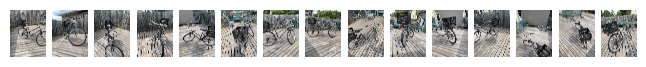

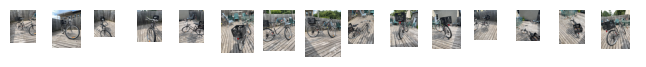

In [197]:
plot_images(original_imgs)
plot_images(resized_imgs)